# Table of Contents
* [Stage 3 - load data](#Stage-3---load-data)
* [process data](#process-data)
* [bonuses](#bonuses)
* [analysis](#analysis)
	* [flaw finding](#flaw-finding)
	* [pd](#pd)
	* [empty_workers](#empty_workers)
* [create subtask data](#create-subtask-data)
* [bounding box clustering](#bounding-box-clustering)
* [bonus cost estimate](#bonus-cost-estimate)
* [HTML Review](#HTML-Review)
* [hide](#hide)


In [2]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import select_labels
from amt_utils.bboxes import cluster_and_label
import warnings
warnings.filterwarnings('ignore')

In [3]:
import ai2.vision.utils as ai2vu

# Stage 3 - load data 

In [79]:
data_file_path = '../../build_dataset/dataset_v0p1.pkl'
ds_stage_1 = unpickle_this(data_file_path)

In [22]:
stage_3b_beta_1_res = unpickle_this('stage_3b_beta_1.pkl')

In [23]:
stage_3b_beta_2_res = unpickle_this('stage_3b_beta2_results.pkl')

In [44]:
stage_3b_beta_locs = unpickle_this('stage3_prod1_settings.pkl')

In [37]:
stage_3b_beta_3_res = unpickle_this('stage_3b_beta3_results.pkl')

In [124]:
stage_3b_prod1_res = unpickle_this('stage_3b_prod1_results.pkl')

In [125]:
stage_3b_prod2_res = unpickle_this('recent_results_9_11.pkl')

In [95]:
ds_by_frame = {anno['globalID']: anno for anno in ds_stage_1}

# process data

In [96]:
def create_result(assmt):
    result = {}
    try:
        raw_result = json.loads(assmt.answers[0][0].fields[0])
        result['gif_uri'] = raw_result[0]['image_url']
        result['image_id'] = raw_result[0]['image_url'].rsplit('/', maxsplit=1)[-1][:-4]
    #     result['setting_description'] = raw_result[0]['description']
        result['action_description'] = raw_result[0]['description']
        result['asgmt_id'] = assmt.AssignmentId
        result['hit_id'] = assmt.HITId
        result['worker_id'] = assmt.WorkerId
        return result
    except json.JSONDecodeError:
        return None

In [97]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

In [120]:
turk_data = stage_3b_prod1_res + stage_3b_prod2_res

TypeError: unsupported operand type(s) for +: 'collections.defaultdict' and 'list'

In [99]:
len(turk_data)

2000

In [126]:
assignments =[]
for assignment_triple in list(stage_3b_prod1_res.values()) + stage_3b_prod2_res:
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]

In [127]:
assignment_results = [a for a in assignment_results if a]

In [128]:
len(assignment_results)

8478

In [129]:
st3_df = pd.DataFrame(assignment_results)
setting_lookup = st3_df['action_description']
setting_lookup.index = st3_df['image_id']

In [130]:
st3_df.shape

(8478, 6)

In [131]:
st3_df.head(50)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id
0,Barney is scared by a large orange claw coming...,3BV8HQ2ZZX1SJVMTX82JWO3U1WP6A9,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EAWOID6MUXEAO5IGC8WUQCVMPG0VO,s_05_e_09_shot_032756_032830,A1B22TUTP9XR1D
1,Old Sheriff man is sitting at a table in the d...,3TMFV4NEP9ECUM8KRSV9YRWCZAFW8T,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3OB6JN3A9RPJKVV8WXQKRQU54M5MRT,s_02_e_02_shot_010182_010256,A11XGDVL8AQ6VL
2,Fred and barney stand in the doorway to the ho...,3KGTPGBS6YLOG3HQGB776CYCSUE2UZ,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3IHWR4LC7EDR67QLC9MS8GSJXLWI8W,s_02_e_07_shot_009401_009475,A2DRV5CGGW5HTK
3,Wilma and Fred are standing by the doorway. Wi...,3GA6AFUKOPO8WZ7PKCED67EE4043H2,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3V7ICJJAZBGG0YPDUW4Y5H8109FB48,s_03_e_02_shot_033009_033083,AAI32CU3ZUGGV
4,Wilma is in a bedroom. She is crying in bed. ...,3TVSS0C0E20VS608UQ64PNSZDNVWTD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,39TX062QX2O2V59AZERXK97N5C7X3I,s_03_e_19_shot_041459_041533,A39AXTTH0QVFA3
5,Barney is outside. His head is wrapped up and...,3VP0C6EFSHWTLWVIUBSO5FYUVDBM66,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EHIMLB7F8ZRACF16R4784R4X8I8HU,s_03_e_12_shot_012232_012306,A39AXTTH0QVFA3
6,A purple dino is standing in the backyard and ...,32RIADZIST4I4449VKVVKQDMRBL4SD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,37VUR2VJ6BPII4K0LEHRI37G6A61CT,s_05_e_01_shot_023023_023097,AAI32CU3ZUGGV
7,A man in orange tunic is walking in the street...,37WLF8U1WQQYV8VF9ZF8Q26Q68C6KH,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3X0EMNLXEQPHY592XXNM9RD3UXRPVJ,s_01_e_07_shot_027419_027493,A164LU3V7YITK7
8,Fred walks up to creepella gruesome in the roo...,3JBT3HLQF921U9C6OWHRJHLK5MIZP5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3XBXDSS889JJB9ZZ5KVXGV145YZLXL,s_05_e_09_shot_041787_041861,A37X1GHLB2HCX7
9,Fred stands behind a lady in a blue dress who ...,3U0SRXB7CE5SPXE2Y0AMTPEQWQVRN5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3421H3BM9BHNFNT1ZJD6KD2UU62J9X,s_06_e_23_shot_012023_012097,A4UVNGSXE2ANA


In [139]:
st3_df['description_length'] = st3_df['action_description'].apply(lambda x: len(x.split()))

In [144]:
def make_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
#     plt.savefig(outfile, bbox_inches='tight')

In [145]:
fig_labels = {
    'fig_title': '# Description Lengths', 
    'x_label': '# Words',
    'y_label': '# Videos'
}

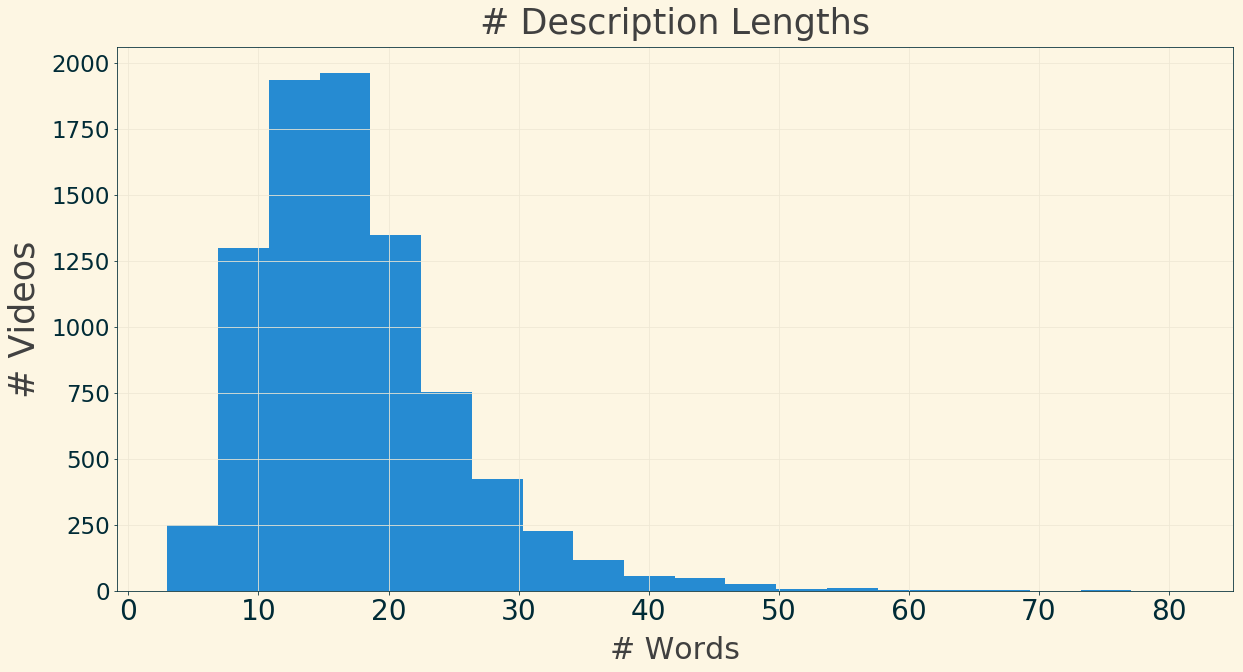

In [146]:
len_hist = st3_df['description_length'].hist(bins=20)
make_standard_fig(len_hist, fig_labels)

In [147]:
st3_df.sort_values('description_length').head(50)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id,description_length
4672,Barney talks outside.,3P4RDNWND66JD8KYTFOLMQWI0D9IJW,https://s3-us-west-2.amazonaws.com/ai2-vision-...,34HEO7RUG7UIIUMJZU0FIZZ5A7MRAO,s_05_e_16_shot_018205_018279,A37X1GHLB2HCX7,3
5275,Fred panics outside.,3FFJ6VRIL2OCB2JC77EF4LHM143I0P,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3WGZLY9VCIMAYWAZKVLHHJC65IWD81,s_06_e_17_shot_034155_034229,A37X1GHLB2HCX7,3
6165,Dino is running outside,3ZSANO2JCG7S2K1YF1REBUADG4XFSL,https://s3-us-west-2.amazonaws.com/ai2-vision-...,368IUKXGA68WJFU1WPFEXZX4D6A6PN,s_01_e_24_shot_003916_003990,A3NT88H0W7T972,4
6012,Wilma in the kitchen.,3EF8EXOTT2V8D2O0L83FURFWJB1J18,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3T2HW4QDUW7079NVPRWKX9PZ4O39CN,s_05_e_10_shot_024473_024547,A21CL0CQ740YN1,4
1983,fred in a room,34Z02EIMITD2KGZN1JDJISJVCKQ0TT,https://s3-us-west-2.amazonaws.com/ai2-vision-...,30U1YOGZGBWSHGP8YTRMYAC7HBRSD2,s_04_e_14_shot_011515_011589,A310MGJ893ZPQG,4
1248,Fred is outside laughing.,3L2IS5HSFBIK5P6J2U5RY01A3P5NUB,https://s3-us-west-2.amazonaws.com/ai2-vision-...,37M4O367VKIUF8XAZQDHOPP9C4G5MY,s_04_e_16_shot_042075_042149,A9Q0ILX5EA5V0,4
1967,wilma is talking outside,3NS0A6KXC58VHWJ7LDR4P87S4X0ZGA,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3LEG2HW4UGNWA1M6VK76VS2OVU8F2X,s_06_e_08_shot_036674_036748,A310MGJ893ZPQG,4
2427,Fred is outside talking.,3TMFV4NEP9ECUM8KRSV9YRWCZCJ8WD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,34YWR3PJ29A6EDADGR9EIB9G21L0XQ,s_05_e_18_shot_017796_017870,A27H6WMJBXIOKI,4
6597,Wilma and betty outside.,31T4R4OBOTGZGAXW0W328XTEWDW7CJ,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3YGYP136429P2DG88Y5K45J59ENNR6,s_02_e_15_shot_031909_031983,A21CL0CQ740YN1,4
6292,"Barney is outside, talking.",3NKQQ8O39Z5BJDF6D0RO2VPGPO2UD5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,378G7J1SJMYQG3KHETC71HXDN11EWB,s_01_e_06_shot_033979_034053,AFKVZ668VGUY9,4


In [148]:
st3_df['setting'] = st3_df['image_id'].apply(lambda x: stage_3b_beta_locs[x])
st3_df['characters'] = st3_df['image_id'].apply(lambda x: [c['characterName'] for c in ds_by_frame[x]['characters']])

In [149]:
len(ds_by_frame)

10893

In [150]:
# st3_df['char_name'] = st3_df['image_id'].apply(lambda x:[char['characterName'] for char in ds_by_frame[x]['characters']])

In [152]:
st3_df.shape

(8478, 9)

In [153]:
st3_df.sample(100)[['image_id', 'gif_uri', 'action_description', 'setting', 'characters']].to_csv('stage3b_prod_2_100_sample.csv', index=False)

In [349]:
# pickle_this(setting_lookup.to_dict(), 'stage_3_beta_gold_settings.pkl')

# region experiment

In [194]:
def lookup_region(hitid):
    if hitid in nzaucaus_hit_ids:
        return 'nzaucaus'
    if hitid in us_hit_ids:
        return 'us only'
    if hitid in in_hit_ids:
        return 'in only'

In [195]:
# st3_df['region'] = st3_df['hit_id'].apply(lookup_region)

In [16]:
st3_df.head(1)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id
0,Fred and Barney are standing in front of a bui...,3BWI6RSP7H9ED8HAWN9XYLTHHFZ7EI,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3N2YPY1GI7YD1EKCOJ7BFFEZGPEEVA,s_04_e_07_shot_000088_000162,A3EAOSOUQZFVFS


In [379]:
grouped_by_image = st3_df.groupby('image_id')

In [23]:
st3_df[['image_id', 'gif_uri', 'action_description']].to_csv('stage_3b_beta_1.csv')

In [392]:
settings_per_turker = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
settings_per_turker = settings_per_turker.reset_index()
settings_per_turker.columns = ['image_id'] + ['turker{}  setting: '.format(i) for i in range(1, 4)]

In [18]:
# settings_per_turker

In [355]:
# settings_per_region = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
# actions_per_region = grouped_by_image['character_description'].apply(lambda x: pd.Series(x.values)).unstack()
# region_s = grouped_by_image['region'].apply(lambda x: pd.Series(x.values)).unstack()

# region_cols = region_s.iloc[0][[0, 1, 2]].values.tolist()

# settings_per_region.columns = ['setting: ' + reg for reg in region_cols]
# actions_per_region.columns = ['actions: ' + reg for reg in region_cols]
# settings_per_region = settings_per_region.reset_index()
# actions_per_region = actions_per_region.reset_index()

In [388]:
gif_uris = grouped_by_image['gif_uri'].agg(np.max)

In [19]:
# settings_per_turker

In [397]:
beta_reponses_df = pd.merge(pd.DataFrame(gif_uris).reset_index(), settings_per_turker)

In [398]:
beta_reponses_df

,image_id,gif_uri,turker1 setting:,turker2 setting:,turker3 setting:
0,s_01_e_03_shot_036331_036405,https://s3-us-west-2.amazonaws.com/ai2-vision-...,quarry,quarry,Quarry
1,s_01_e_04_shot_020768_020842,https://s3-us-west-2.amazonaws.com/ai2-vision-...,room,Living room,Quarry
2,s_01_e_04_shot_036045_036119,https://s3-us-west-2.amazonaws.com/ai2-vision-...,Doorway,doorway,Entry way
3,s_01_e_05_shot_006248_006322,https://s3-us-west-2.amazonaws.com/ai2-vision-...,inside house,Dining room,table inside\n
4,s_01_e_06_shot_033979_034053,https://s3-us-west-2.amazonaws.com/ai2-vision-...,Outside,outside,outside
5,s_01_e_07_shot_027719_027793,https://s3-us-west-2.amazonaws.com/ai2-vision-...,sidewalk,street,roadway
6,s_01_e_08_shot_035035_035109,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,Living room,living room
7,s_01_e_10_shot_002849_002923,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,room,inside house
8,s_01_e_10_shot_028169_028243,https://s3-us-west-2.amazonaws.com/ai2-vision-...,room,green room,indoors
9,s_01_e_11_shot_000814_000888,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,living room,living room


In [399]:
# per_region_df['char_name'] = per_region_df['image_id'].apply(lambda x: ds_by_frame[x]['characters'][0]['characterName'])

In [400]:
# pickle_this(set(per_region_df['image_id'].tolist()), 'random_sample_ids.pkl')

In [403]:
beta_reponses_df.to_csv('stage_3b_beta_1.csv')

In [402]:
# annotations_by_frame = defaultdict(list)
# for anno in sorted(assignment_results, key=lambda x: x['stillID']):
#     animation_id = anno['stillID'].rsplit('_', 1)[0]
#     annotations_by_frame[animation_id].append(anno)

# analysis

## flaw finding

In [189]:
from amt_utils.flintstones import display_image

In [620]:
results_by_still = defaultdict(dict)
for anno in characters_present:
    results_by_still[anno['still_id']][anno['w_id']] = anno
results_by_still = dict(results_by_still)

In [621]:
len(results_by_still)

20000

In [1115]:
missing_turker_stills = []

worker_flaws = {
    'self_inconsistent_empty_frame' : [],
    'disagree_on_empty': [],
    'disagree_on_number': []
}


for still, still_annos in list(results_by_still.items()):
    char_sets = {w_anno['w_id']: w_anno['characters'] for w_anno in still_annos.values()}
    if len(char_sets) < 3:
        missing_turker_stills.append(still)
        continue
    char_set_lengths = {w_anno['w_id']: len(w_anno['characters']) for w_anno in still_annos.values()}
    mode_chars = st.mode(list(char_set_lengths.values()))
    mode_count = mode_chars.count[0]
    mode_set = mode_chars.mode[0]
    if mode_count == 2:
        try:
            dis_wid = [dis_wid for dis_wid, count in char_set_lengths.items() if count != mode_set][0]
            worker_flaws['disagree_on_number'].append({dis_wid: still})
        except IndexError:
            print(still)
    all_chars = set()
    _ = [all_chars.update(char_set) for char_set in char_sets.values()]
    for wid, char_set in char_sets.items():
        if 'empty frame' in char_set:
            if len(char_set) > 1:
                worker_flaws['self_inconsistent_empty_frame'].append({wid: still})
            elif len({owid:chars for owid, chars in char_sets.items() if (owid != wid and chars.difference({'empty frame'}))}) > 1:
                worker_flaws['disagree_on_empty'].append({wid: still})
    if all_chars.difference(set(main_characters)):
        continue
   

In [1116]:
len(missing_turker_stills)

163

In [1118]:
worker_flaws['disagree_on_number']

[{'A26ERTJPV1A1IM': 's_05_e_22_shot_016214_016288_40.png'},
 {'A3UPV16IECELHV': 's_02_e_17_shot_000755_000829_40.png'},
 {'A28URN0B675OIE': 's_06_e_22_shot_016698_016772_40.png'},
 {'A3UPV16IECELHV': 's_01_e_14_shot_031636_031710_40.png'},
 {'A1KUCRDRXEUGW3': 's_04_e_20_shot_028325_028399_40.png'},
 {'AO23DKI6107TH': 's_06_e_21_shot_018280_018354_40.png'},
 {'A3HDMR3ZFQVT7B': 's_02_e_30_shot_021948_022022_40.png'},
 {'A1KJR0VT46ZV5I': 's_02_e_20_shot_013783_013857_40.png'},
 {'A9ALF1SODWQE5': 's_04_e_03_shot_002717_002791_40.png'},
 {'A3HDMR3ZFQVT7B': 's_04_e_01_shot_028343_028417_40.png'},
 {'A3UPV16IECELHV': 's_06_e_10_shot_026827_026901_40.png'},
 {'A2J0W73DZ7I4RR': 's_06_e_21_shot_010998_011072_40.png'},
 {'A3UPV16IECELHV': 's_04_e_12_shot_024627_024701_40.png'},
 {'A2CXEAMWU2SFV3': 's_01_e_02_shot_015550_015624_40.png'},
 {'A28WKEUHQLFVS3': 's_01_e_13_shot_022770_022844_40.png'},
 {'A3UPV16IECELHV': 's_02_e_27_shot_037433_037507_40.png'},
 {'A3I8WDKEEUWM81': 's_04_e_17_shot_009271

In [1097]:
# test_stills = {'test': results_by_still[still_to_inspect]}

In [1145]:
char_number_disagree = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_number']]).value_counts()
char_number_disagree = char_number_disagree[char_number_disagree > 100]

In [1146]:
incons_empty_frames = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['self_inconsistent_empty_frame']]).value_counts()

In [1147]:
disagree_empty_frame = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_empty']]).value_counts()

In [1148]:
two_flawed_workers = set(incons_empty_frames.index).intersection(set(disagree_empty_frame.index))

In [1149]:
len(two_flawed_workers)

28

In [1155]:
prolific_workers = all_chars_agged[all_chars_agged > 200]
suspect_workers = set(prolific_workers.index).intersection(char_number_disagree.index).difference(to_reject_empty).difference(to_reject_all)
sw_list = list(suspect_workers)

In [1156]:
len(suspect_workers)

6

In [1323]:
most_prolific = set(prolific_workers.sort_values(ascending=False)[:5].index)

In [1322]:
prolific_workers.sort_values(ascending=False)[:10]

w_id
A3UPV16IECELHV    5490
A3HDMR3ZFQVT7B    4496
A1CF1W8CP0DHB0    2156
A1RULXRXR2XF6M    1683
A2X7BE2FSPUKCK    1606
A2CXEAMWU2SFV3    1383
A1QP6651C4Q8NS    1371
A2R65L9397776L    1315
A3R6KO03P9QLNO    1069
A3D61CCA0LVMWV     997
Name: characters, dtype: int64

In [1324]:
most_prolific.intersection(to_reject_all)

{'A1CF1W8CP0DHB0', 'A2X7BE2FSPUKCK'}

In [1197]:
to_reject_empty = {'A15DOG6AXQ7LGY', 'A3R6KO03P9QLNO', 'A1IOMFFEKCWOIT', 'A1RULXRXR2XF6M', 'A2L97S8Z5FZK5N', 'A3UPV16IECELHV', 'A2NJTYYY37DNO', 'A3UPV16IECELHV', 'A3HDMR3ZFQVT7B'}

In [1299]:
to_reject_all = {'A273GB71FE8RIV', 'A2CXEAMWU2SFV3', 'A13ISH3PAGHO0A', 'A1QP6651C4Q8NS', 'A1QP6651C4Q8NS', 'A9ALF1SODWQE5', 'A2X7BE2FSPUKCK', 'A2PU4YNWITAQVL', 'A1CF1W8CP0DHB0'}

In [1325]:
worker_ln = 5
suspect_worker_df = char_df[char_df['w_id'] == 'A1CF1W8CP0DHB0']
sw_list[worker_ln]

'A1CF1W8CP0DHB0'

['barney']


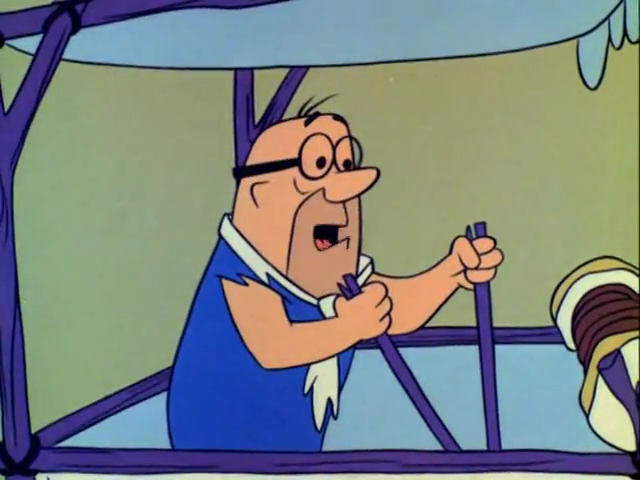

In [1339]:
rown = random.randint(0, suspect_worker_df.shape[0])
still_to_inspect = suspect_worker_df.iloc[rown]['still_id']
print(suspect_worker_df.iloc[rown]['characters'])
display_image(still_to_inspect)

In [1302]:
all_empty_suspect_df = char_df[char_df['w_id'].isin(to_reject_empty)]
all_total_suspect_df = char_df[char_df['w_id'].isin(to_reject_all)]

In [1314]:
len(all_total_suspect_df)

7420

In [1303]:
all_empty_suspect_df_e_only = all_empty_suspect_df[all_empty_suspect_df['characters'].apply(lambda x: 'empty frame' in x)]

In [1313]:
len(all_empty_suspect_df_e_only)

2034

In [1304]:
assignemnts_to_reject = set(all_empty_suspect_df_e_only['asgnmt_id'].tolist()).union(set(all_total_suspect_df['asgnmt_id'].tolist()))

In [1307]:
len(assignemnts_to_reject)

9454

In [1308]:
to_reject_empty

{'A15DOG6AXQ7LGY',
 'A1IOMFFEKCWOIT',
 'A1RULXRXR2XF6M',
 'A2L97S8Z5FZK5N',
 'A2NJTYYY37DNO',
 'A3R6KO03P9QLNO',
 'A3UPV16IECELHV'}

In [1340]:
pickle_this(to_reject_empty.union(to_reject_all), 'workers_to_ban_prod_1_4.pkl')

In [1341]:
pickle_this(assignemnts_to_reject, 'assignments_to_reject_prod_1_4.pkl')

## pd

In [63]:
def make_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
#     plt.savefig(outfile, bbox_inches='tight')

In [64]:
char_df = pd.DataFrame(characters_present)
char_df['aid'] = char_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))
char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]

In [65]:
char_ser = pd.Series(all_chars)

In [66]:
char_counts = char_ser.value_counts()

In [67]:
fig_labels = {
    'fig_title': 'Character Frequency', 
    'x_label': 'Character',
    'y_label': '# Occurrences'
}

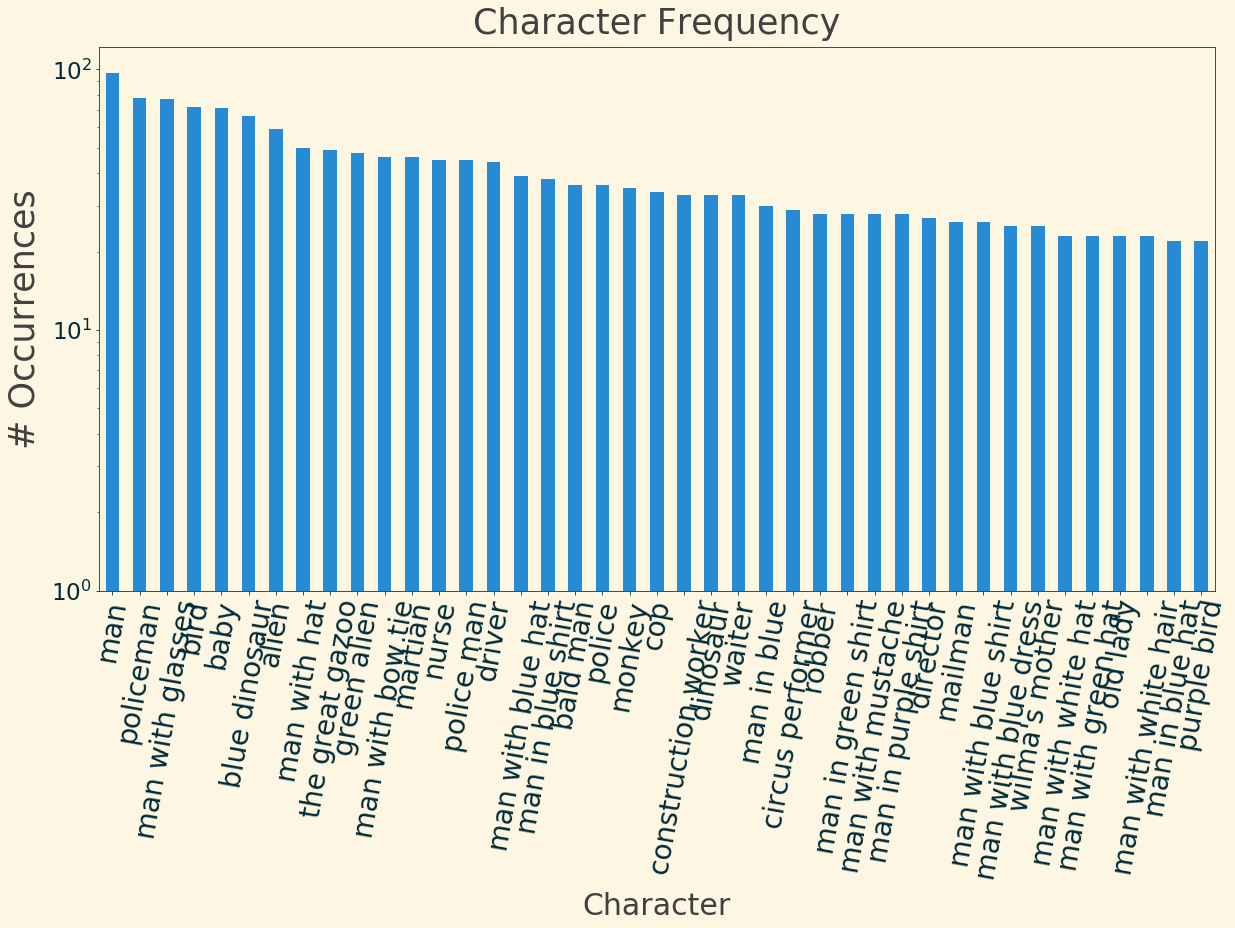

In [68]:
char_hist = char_counts[(char_counts > 20) &  (char_counts < 100)].plot(kind="bar", log=True)
plt.xticks(rotation=80) 
make_standard_fig(char_hist, fig_labels)

In [69]:
# sample_row = char_df[char_df['w_id'] == 'A3R6KO03P9QLNO']
# sample_row =  sample_row[sample_row['characters'].apply(lambda x: bool(x.intersection({'empty frame'})))].iloc[random.randint(0, 100)]
# print(sample_row['characters'])
# display_image(sample_row['still_id'])

In [70]:
grouped_by_still = char_df.groupby('still_id')
agg_df = grouped_by_still.aggregate(len)

agged_on_mode = grouped_by_still.agg(lambda x: st.mode(x))

In [71]:
consensus_results_df = agged_on_mode.reset_index()

consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())
not_main_df = char_df[char_df['still_id'].isin(not_main)]


all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

all_agree_set = set(all_agree['still_id'].tolist())

count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

conflict_images = set(disagree['still_id'].tolist())

conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [76]:
consensus_count_df = consensus_results_df[consensus_results_df['count_mode'] > 1]


In [81]:
consensus_count_df['frame_char_count'] = consensus_count_df['n_chars'].apply(lambda x: x[0][0])

In [90]:
fig_labels = {
    'fig_title': '# Characters in Frame', 
    'x_label': '# Characters',
    'y_label': '# Frames'
}

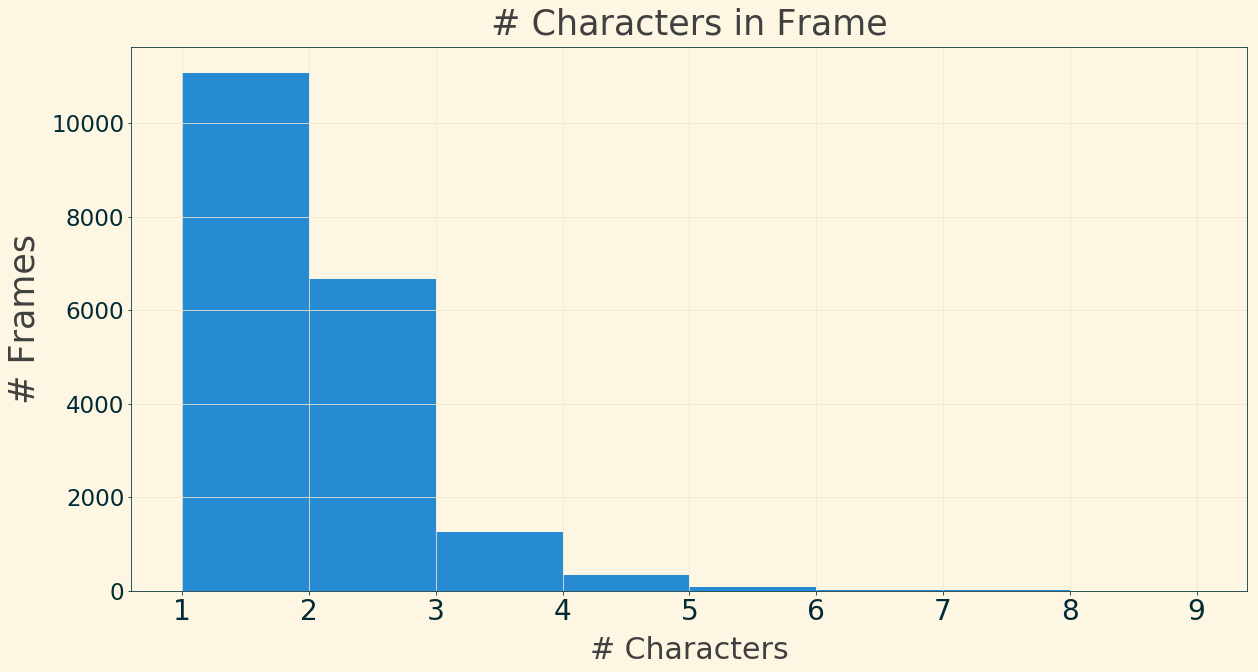

In [103]:
_ = consensus_count_df[consensus_count_df['frame_char_count'] < 11]['frame_char_count'].hist(bins=8)
# plt.xticks(rotation=80) 
make_standard_fig(char_hist, fig_labels)

In [644]:
char_df['characters'] = char_df['characters'].apply(lambda x: list(x))
grouped_by_worker = char_df.groupby('w_id')

In [645]:
w_agged = grouped_by_worker['characters'].sum()

del_hit = 'A1D9FOXZ0UT0L2'

w_agged = w_agged[~w_agged.index.str.contains(del_hit)]

# unique_chars = w_agged.apply(lambda x: len(x) /len(set(x)))

empty_fraction = w_agged.apply(lambda x: len([char for char in x if char == 'empty frame'])/ len(x))

empty_workers = empty_fraction[empty_fraction.sort_values(ascending=False) > 0.2]

In [646]:
empty_workers.index.intersection(set(prolific_workers.index))

Index([], dtype='object')

In [647]:
all_chars_agged = w_agged.apply(lambda x: len(x))

In [648]:
prolific_workers = all_chars_agged[all_chars_agged > 100]

suspect_workers = set(prolific_workers.index).intersection(set(empty_workers.index))

## empty_workers

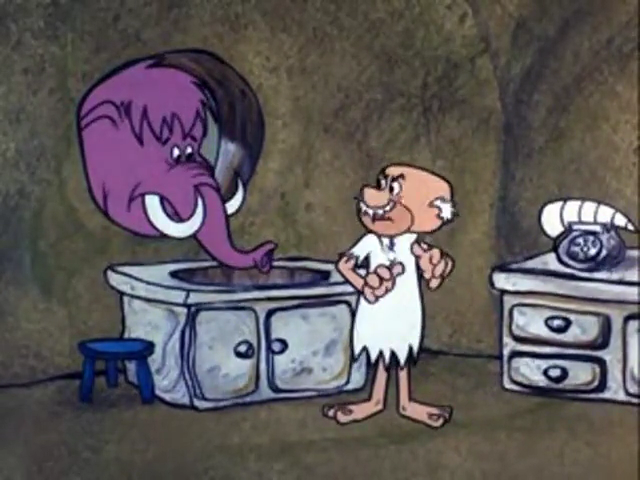

In [487]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_04_e_05_shot_015403_015477_40.png'
Image.open(requests.get(image_url, stream=True).raw)

In [799]:
char_df['characters'].apply(lambda x: [c for c in x if c != 'empty frame']).apply(lambda x: len(x)).mean()

1.4475733672036901

In [800]:
1632 * (1 + 1.38)

3884.16

In [305]:
# char_df[char_df['w_id'].isin(suspect_workers)][400:]

In [801]:
mono_worker = unique_chars[unique_chars < 5]

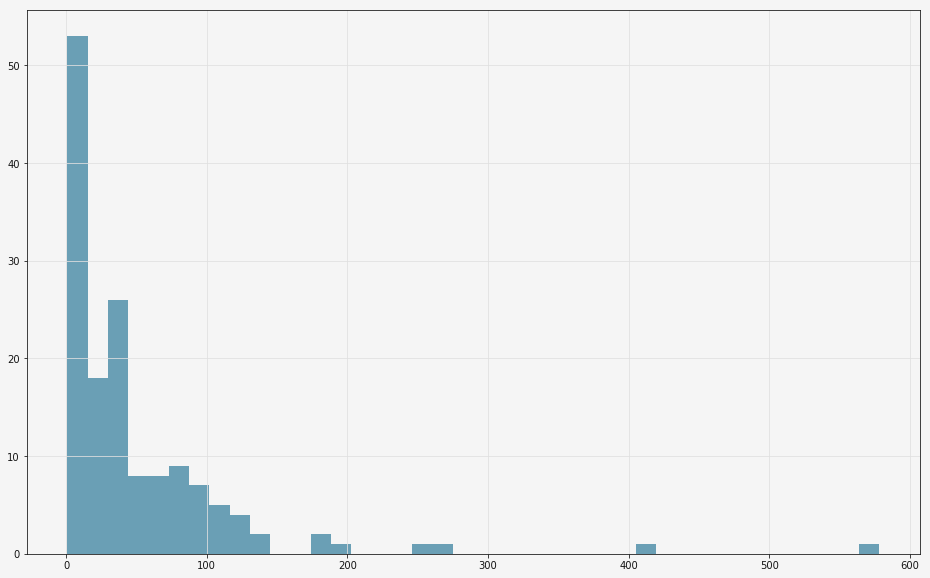

In [211]:
_ = all_chars.hist(bins=40)

In [154]:
consensus_results_df[consensus_results_df['two_agree']]

,still_id,characters,h_id,w_id,aid,all_main,n_chars,count_mode,mode_count,all_agree,two_agree
34,s_01_e_06_shot_021230_021304_40.png,"([{man with scarf and cap, man with blue glass...","([3NQUW096N78TADH124PJ0SFMXC29LH], [3])","([A1CUIN1FSZCM50], [1])","([s_01_e_06_shot_021230_021304], [3])","([False], [2])","([2], [2])",2,1,False,True
35,s_01_e_06_shot_023265_023339_40.png,"([{fred}], [1])","([3D17ECOUOFVU54OHSL6QP03MZEM31N], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_06_shot_023265_023339], [3])","([False], [2])","([2], [2])",2,1,False,True
41,s_01_e_07_shot_007742_007816_40.png,"([{barney}], [1])","([307L9TDWJZSXJBV6X84OM7GP2FS3NW], [3])","([A1J8Y204VZNWQW], [1])","([s_01_e_07_shot_007742_007816], [3])","([False], [2])","([1], [2])",2,1,False,True
52,s_01_e_13_shot_014034_014108_40.png,"([{fred}], [1])","([3MGHRFQY2MPVEI0NLNVG1PGP3NBY0L], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_13_shot_014034_014108], [3])","([True], [3])","([1], [2])",2,1,False,True
55,s_01_e_13_shot_028290_028364_40.png,"([{betty, wilma}], [1])","([37NXA7GVSU6R7KU455UFSA4JO4KVLI], [3])","([A26699AEVYMM7N], [1])","([s_01_e_13_shot_028290_028364], [3])","([False], [2])","([3], [2])",2,1,False,True
60,s_01_e_14_shot_014144_014218_40.png,"([{fred, wilma}], [2])","([3CMV9YRYP41IGPUAOGGWPMTPTHCJLK], [3])","([A1OFOVU6TCQ2K3], [1])","([s_01_e_14_shot_014144_014218], [3])","([True], [3])","([2], [2])",2,2,False,True
62,s_01_e_14_shot_024354_024428_40.png,"([{fred}], [1])","([32CAVSKPCFPE4Y10752RC9TMCR5U1L], [2])","([A2QG1N2LFV0VXW], [1])","([s_01_e_14_shot_024354_024428], [2])","([True], [2])","([1], [2])",2,1,False,True
65,s_01_e_16_shot_006532_006606_40.png,"([{wilma}], [2])","([3MQY1YVHS4K6XKAQQILAC2B3FCD2BU], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_006532_006606], [3])","([True], [2])","([1], [2])",2,2,False,True
66,s_01_e_16_shot_013486_013560_40.png,"([{fred, barney}], [2])","([3XBYQ44Z6Q4S5M2E4O1203XEPQ8TWT], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_013486_013560], [3])","([True], [3])","([2], [2])",2,2,False,True
70,s_01_e_16_shot_025041_025115_40.png,"([{fred, barney}], [2])","([3RWO3EJELI91CTT4QJ3X236N4AE1PX], [2])","([A1HA4T6P2CM2WV], [1])","([s_01_e_16_shot_025041_025115], [2])","([True], [2])","([2], [2])",2,2,False,True


In [138]:
600 * 3 * 3

5400

In [139]:
char_df.shape[0] * 0.05

243.4

In [816]:
char_counts = pd.Series(all_chars).value_counts()

In [821]:
char_counts[char_counts < 35].sum()

13206

In [142]:
char_counts[char_counts < 16].sum()

932

In [143]:
char_df['empty'] = ~char_df['characters'].apply(lambda x:bool(x.difference(set(empty_characters))))

In [144]:
char_df['nonmain_characters'] = char_df['characters'].apply(lambda x: len(x.difference(set(main_characters))))

In [145]:
grouped_by_aid = char_df.groupby('aid')

In [146]:
grouped_by_aid.agg(max)['nonmain_characters'].sum()

708

In [147]:
grouped_by_aid.agg(max).shape

(1632, 8)

In [148]:
grouped_by_aid.agg(max)['nonmain_characters'].sum() * 3 * 3  * 0.02

127.44

In [150]:
# grouped_by_aid.agg(max)[grouped_by_aid.agg(min)['empty'] == True]

In [151]:
grouped_by_aid.agg(min)['empty'].sum()

73

In [152]:
grouped_by_aid.agg(max).shape

(1632, 8)

# HTML Review

## generate

## page_code

In [147]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_single_frame_page_html = """
<!DOCTYPE html>
<html>JM
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [148]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'


def make_uri(clip_id, s3_base='review_frames/', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base=s3_base_path):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(review_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_single_image_review_page(rev_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img) for img in rev_seq]
    send_to_template = zip(rev_seq, images_sorted_by_conf)
    env = Environment()
    template =  j2env.from_string(review_single_frame_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [111]:
# page_html = generate_subtask_review(subtask_rev_seq)

# hide

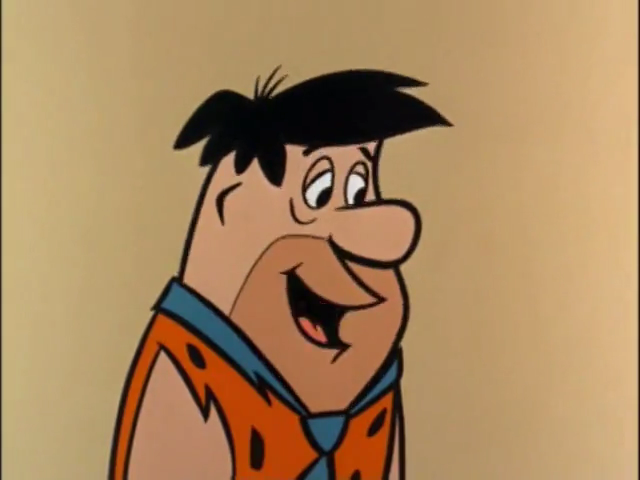

In [465]:
import PIL.Image as Image
import requests

image_n = 10


s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_01_e_04_shot_012010_012084_70.png'
Image.open(requests.get(image_url, stream=True).raw)